In [98]:
using PyPlot
using ForwardDiff

In [99]:
A = convert(Array{Float64,2},readcsv("binary.csv")[2:end,:][:,1:3]);
function L(x,u)
    a = x[1:2]; β = x[3];
    uᵢ = u[2:3]; yᵢ = u[1]
    return -yᵢ*(vecdot(a,uᵢ) + β) + log(1 + exp(vecdot(a,uᵢ) + β))
end;
G(x,ui) = ForwardDiff.gradient(x -> L(x,ui))(x)
H(x,ui) = ForwardDiff.hessian(x -> L(x,ui))(x)
m = size(A,1)
L(x) = sum([L(x, A[i,:]) for i in 1:m])
G(x) = sum([G(x, A[i,:]) for i in 1:m]);
H(x) = sum([H(x, A[i,:]) for i in 1:m]);

In [100]:
#set up all the variables
x = [0.0,0.0,0.0]
k = 0;  #counter
tau = norm(G(x),2);  #calculate the initial 2-norm of the gradient at x0    

#We exit after |g| < tauGoal.  Here we scale tauGoal based on the initial value of tau
    if tau > 10e5
        tauGoal = tau*10e-10
    elseif tau > 10e3
        tauGoal = tau*10e-4
    elseif tau > 10e-3
        tauGoal = tau*10e-5
    else
        tauGoal = tau*10e-4
    end

alpha = 1;  #a part of the step size for the newton step
mu = 10e-4  #this is for the Armijo backtracking linesearch, it helps define a better condition for an appropriate step size
sigma = 10e-5  #this is the minimum value we will accept for an eigenvalue inside the Hessian

#Main loop.  We exit when |g| is less than a predefined value (ie: we are near a stationary point)
while tau > tauGoal
    #if we max iterations, exit and return the current value
    if k == 10e3
        @printf("Maxed iterations")
        return (k, L(x))
    end
    #condition H so that it is definite positive under all conditions
    C = eigvals(H(x))
    V = eigvecs(H(x))
    for i in 1:1:length(C)
        if abs(C[i]) >= sigma
            C[i] = abs(C[i])
        else
            C[i] = sigma
        end
    end
    C = diagm(vec(C))
    H2 = *(*(V,C),transpose(V))
    #find search direction
    d = H2\-(G(x))

    #Armijo Backtracking
    alpha = 1;
    while L(x + d*alpha) > (L(x) + alpha*mu*dot(G(x),d))
        alpha = alpha/1.5;
    end

    #compute next x
    x = x + alpha * d;

    #clean up for next loop
    k = k + 1;
    tau = norm(G(x),2)
end


In [138]:
function plot_data(A)
    A1 = A[A[:,1] .== 0,:]
    A2 = A[A[:,1] .== 1,:]
    scatter(A1[:,2],A1[:,3], color = "k")
    hold(true)
    scatter(A2[:,2],A2[:,3], color = "r")
end;

In [129]:
function plot_regressor(x)
    a = x[1:2]; β = x[3];
    intercept = (- β) / a[2] - 0.5
    slope = -a[1]/a[2]
    
    g = γ -> intercept + slope*γ

    plot(400:900, g(400:900), color="b")
end;

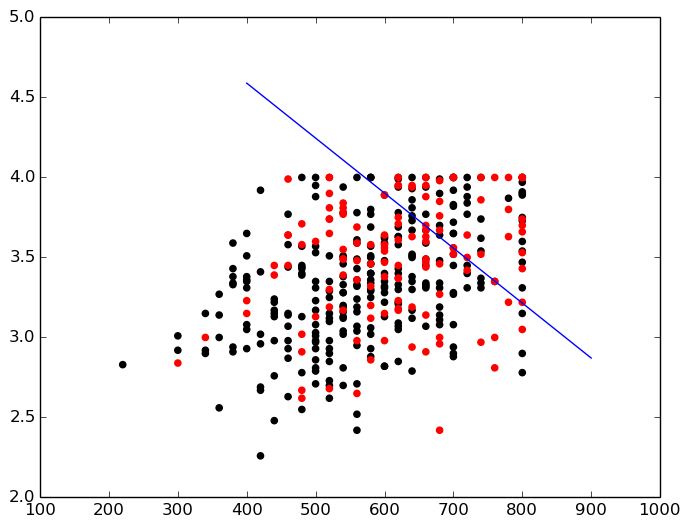

In [139]:
plot_data(A)
hold(true)
plot_regressor(x)
hold(false)

In [128]:
x

3-element Array{Float64,1}:
  0.00262742
  0.76466   
 -4.94264   